<a href="https://colab.research.google.com/github/Melina28072010/Predicting-Health-Risks-Stay-Healthy-Stay-Ahead/blob/main/5_Crossing_The_Finish_Line/Milestone_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

We loaded necessary libraries for data manipulation, model training, evaluation, and visualization.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, log_loss, mean_squared_error, mean_absolute_error,
    r2_score
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load and Preprocess the Dataset**

We read the dataset from Google Drive, droped irrelevant columns, and encoded categorical features.

In [3]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Milestone 4 Data/Datasets/heart_attack_prediction_dataset.csv')

# Drop irrelevant columns
df = df.drop(columns=['Patient ID', 'Country', 'Continent', 'Hemisphere', 'Blood Pressure'])

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded = encoder.fit_transform(df[['Sex', 'Diet']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Sex', 'Diet']), index=df.index)

# Merge and drop original categorical columns
df = pd.concat([df.drop(columns=['Sex', 'Diet']), encoded_df], axis=1)


**Define Features and Target, Then Scale and split**

We defined X and y, scale the features, and split the dataset into training and testing sets.

In [4]:
X = df.drop("Heart Attack Risk", axis=1)
y = df["Heart Attack Risk"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


**Train ML Models**

We train several classifiers: dummy (baseline), logistic, kNN, decision tree, random forest, and XGBoost.

In [5]:
# Dummy Classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)
log_preds = logreg.predict(X_test)
log_probs = logreg.predict_proba(X_test)

# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_resampled, y_train_resampled)
knn_preds = knn.predict(X_test)

# Decision Tree
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train_resampled, y_train_resampled)
tree_preds = tree.predict(X_test)
tree_probs = tree.predict_proba(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)

# AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train_resampled, y_train_resampled)
ada_preds = ada.predict(X_test)
ada_probs = ada.predict_proba(X_test)

# Bagging Classifier
bagging = BaggingClassifier(n_estimators=100, random_state=42)
bagging.fit(X_train_resampled, y_train_resampled)
bagging_preds = bagging.predict(X_test)
bagging_probs = bagging.predict_proba(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


This evaluation helps measure how well the Decision Tree separates classes (using Gini impurity) and how confident and accurate its probability predictions are (using Binary Cross-Entropy).


In [6]:
# Binary Cross-Entropy (Log Loss) for Decision Tree
tree_probs = tree.predict_proba(X_test)
tree_log_loss = log_loss(y_test, tree_probs)
print("Decision Tree Log Loss (Binary Cross-Entropy):", tree_log_loss)

# Average Gini Impurity for test set samples
leaf_indices = tree.apply(X_test)
gini_per_leaf = tree.tree_.impurity[leaf_indices]
average_gini = gini_per_leaf.mean()
print("Average Gini Impurity on Test Set:", average_gini)


Decision Tree Log Loss (Binary Cross-Entropy): 0.6931803214172275
Average Gini Impurity on Test Set: 0.48649738193398934


GridSearchCV helps find the best settings for each model by testing different combinations. It uses cross-validation to make sure results are reliable

In [7]:
# Logistic Regression
logreg_params = {'C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000), logreg_params, cv=3)
logreg_grid.fit(X_train_resampled, y_train_resampled)
logreg_best = logreg_grid.best_estimator_
logreg_preds = logreg_best.predict(X_test)
logreg_probs = logreg_best.predict_proba(X_test)

# k-NN
knn_params = {'n_neighbors': [3, 5, 7, 9]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_grid.fit(X_train_resampled, y_train_resampled)
knn_best = knn_grid.best_estimator_
knn_preds = knn_best.predict(X_test)

# Decision Tree
tree_params = {
    'max_depth': [3, 4, 5, 6],
    'criterion': ['gini', 'entropy']
}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=3)
tree_grid.fit(X_train_resampled, y_train_resampled)
tree_best = tree_grid.best_estimator_
tree_preds = tree_best.predict(X_test)
tree_probs = tree_best.predict_proba(X_test)

# Random Forest
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6, 8]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
rf_grid.fit(X_train_resampled, y_train_resampled)
rf_best = rf_grid.best_estimator_
rf_preds = rf_best.predict(X_test)
rf_probs = rf_best.predict_proba(X_test)

# XGBoost
xgb_params = {
    'n_estimators': [100, 150],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2]
}
xgb_grid = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss', random_state=42), xgb_params, cv=3)
xgb_grid.fit(X_train_resampled, y_train_resampled)
xgb_best = xgb_grid.best_estimator_
xgb_preds = xgb_best.predict(X_test)
xgb_probs = xgb_best.predict_proba(X_test)

# AdaBoost
ada_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.5, 1.0, 1.5]
}
ada_grid = GridSearchCV(AdaBoostClassifier(random_state=42), ada_params, cv=3)
ada_grid.fit(X_train_resampled, y_train_resampled)
ada_best = ada_grid.best_estimator_
ada_preds = ada_best.predict(X_test)
ada_probs = ada_best.predict_proba(X_test)

# Bagging
bagging_params = {
    'n_estimators': [50, 100],
    'max_samples': [0.7],
    'max_features': [0.7]
}
bagging_grid = GridSearchCV(BaggingClassifier(random_state=42), bagging_params, cv=3)
bagging_grid.fit(X_train_resampled, y_train_resampled)
bagging_best = bagging_grid.best_estimator_
bagging_preds = bagging_best.predict(X_test)
bagging_probs = bagging_best.predict_proba(X_test)


**Evaluate classification models with key metrics**

This cell compares all models using key classification metrics, error measures, and confusion matrices, highlighting RMSE and MAE for Dummy and Logistic Regression.


In [8]:
def evaluate_model(name, y_true, y_pred, y_prob=None):
    print(f"\n{name} Evaluation")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_true, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    if y_prob is not None:
        print("Log Loss:", log_loss(y_true, y_prob))
    print("-" * 40)

# Evaluate all models
evaluate_model("Dummy Classifier", y_test, dummy_preds)
evaluate_model("Logistic Regression", y_test, log_preds, log_probs)
evaluate_model("k-NN Classifier", y_test, knn_preds)
evaluate_model("Decision Tree", y_test, tree_preds, tree_probs)
evaluate_model("Random Forest", y_test, rf_preds, rf_probs)
evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)
evaluate_model("AdaBoost", y_test, ada_preds, ada_probs)
evaluate_model("Bagging Classifier", y_test, bagging_preds, bagging_probs)


Dummy Classifier Evaluation
Accuracy: 0.6417569880205363
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[1125    0]
 [ 628    0]]
----------------------------------------

Logistic Regression Evaluation
Accuracy: 0.5173987450085568
Precision: 0.37236533957845436
Recall: 0.5063694267515924
F1 Score: 0.4291497975708502
Confusion Matrix:
 [[589 536]
 [310 318]]
Log Loss: 0.6938842163657591
----------------------------------------

k-NN Classifier Evaluation
Accuracy: 0.48887621220764405
Precision: 0.3397129186602871
Recall: 0.45222929936305734
F1 Score: 0.3879781420765027
Confusion Matrix:
 [[573 552]
 [344 284]]
----------------------------------------

Decision Tree Evaluation
Accuracy: 0.6263548203080433
Precision: 0.3548387096774194
Recall: 0.052547770700636945
F1 Score: 0.09153952843273232
Confusion Matrix:
 [[1065   60]
 [ 595   33]]
Log Loss: 0.8415716065149214
----------------------------------------

Random Forest Evaluation
Accuracy: 0.5453508271534512
Precision: 

**Confusion Matrix Heatmaps**

We created confusion matrix heatmaps to help us visualize how well each model distinguishes between the two classes, by using color-coded confusion matrices.

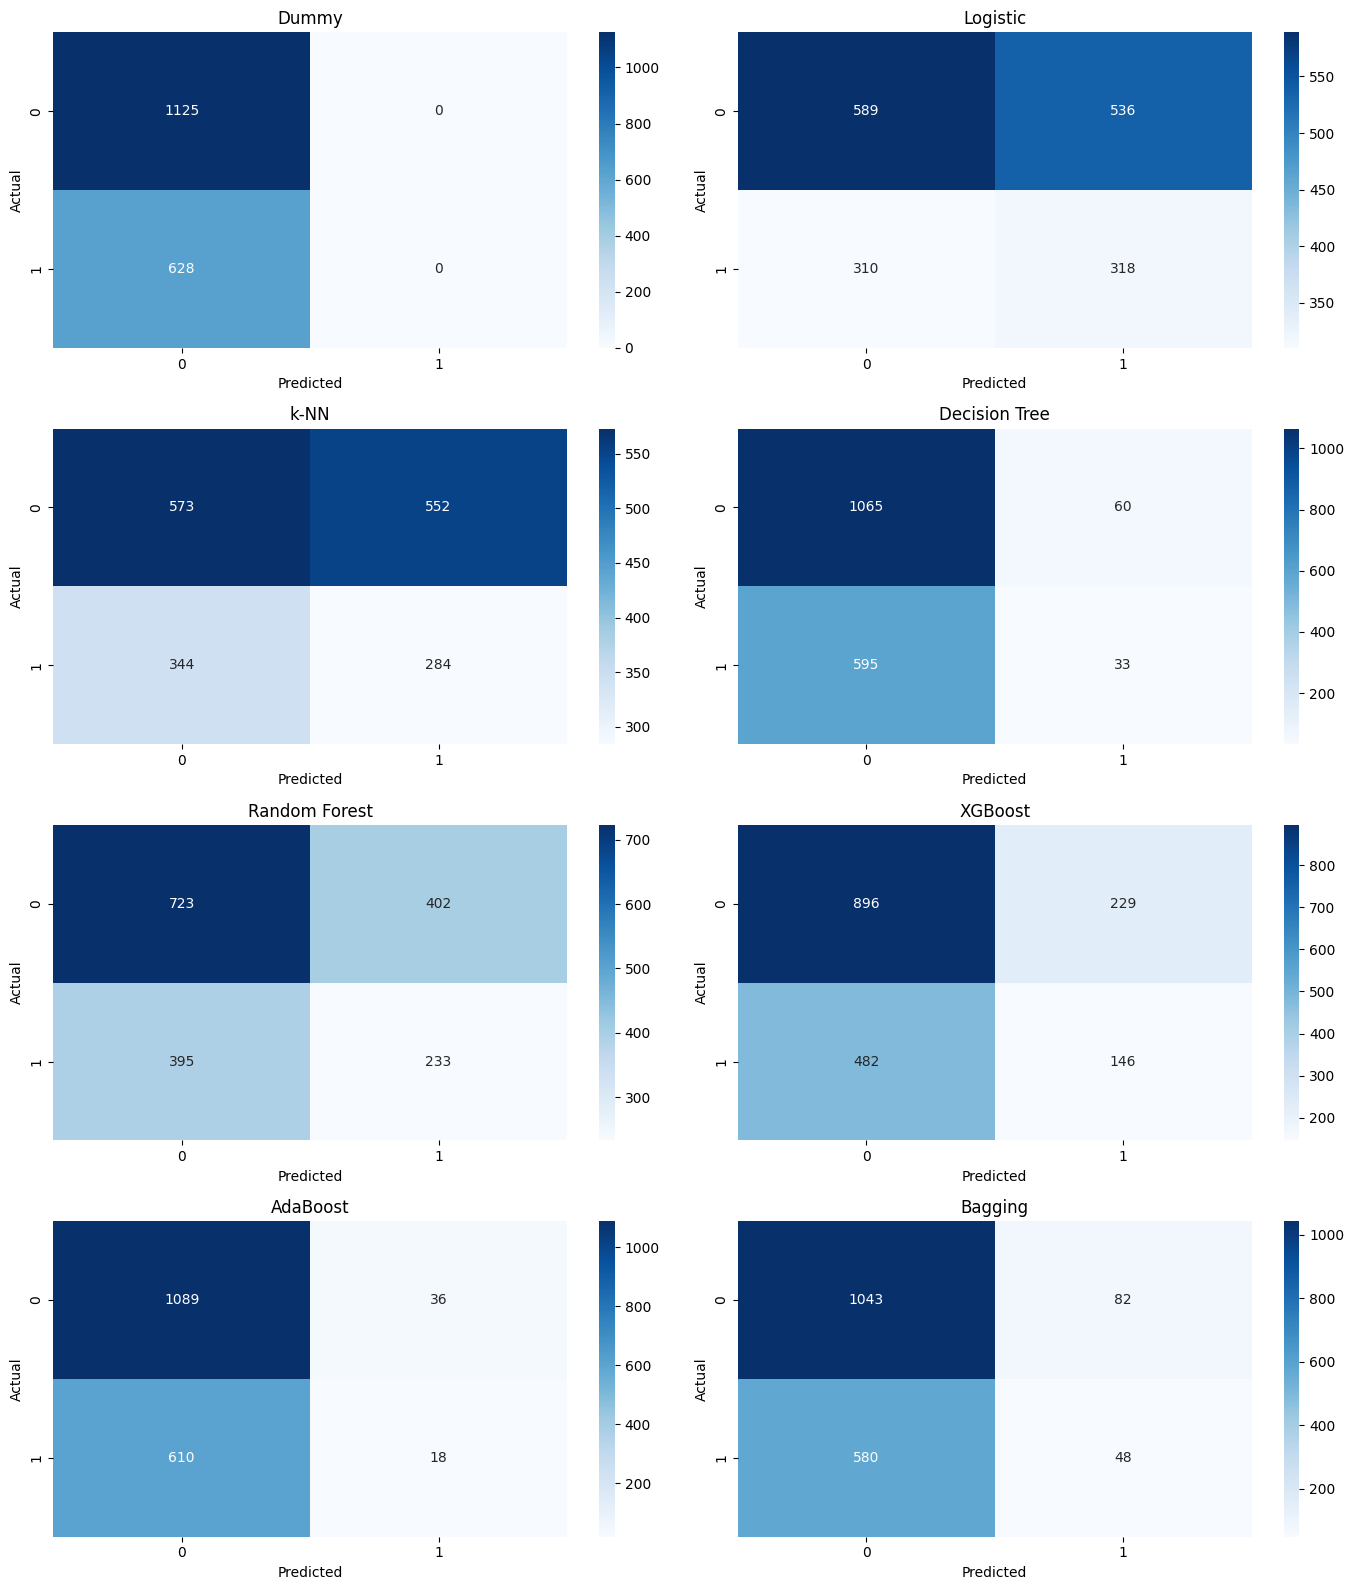

In [9]:
def plot_cm(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set(title=title, xlabel='Predicted', ylabel='Actual')

model_preds = [
    dummy_preds, log_preds, knn_preds, tree_preds,
    rf_preds, xgb_preds, ada_preds, bagging_preds
]

titles = [
    'Dummy', 'Logistic', 'k-NN', 'Decision Tree',
    'Random Forest', 'XGBoost', 'AdaBoost', 'Bagging'
]

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
for ax, pred, title in zip(axes.flat, model_preds, titles):
    plot_cm(ax, y_test, pred, title)

plt.tight_layout()
plt.show()


**Compare Model Metrics in Bar Chart**

We crerated a bar chart to compare accuracy, precision, recall, and F1 score across all models.

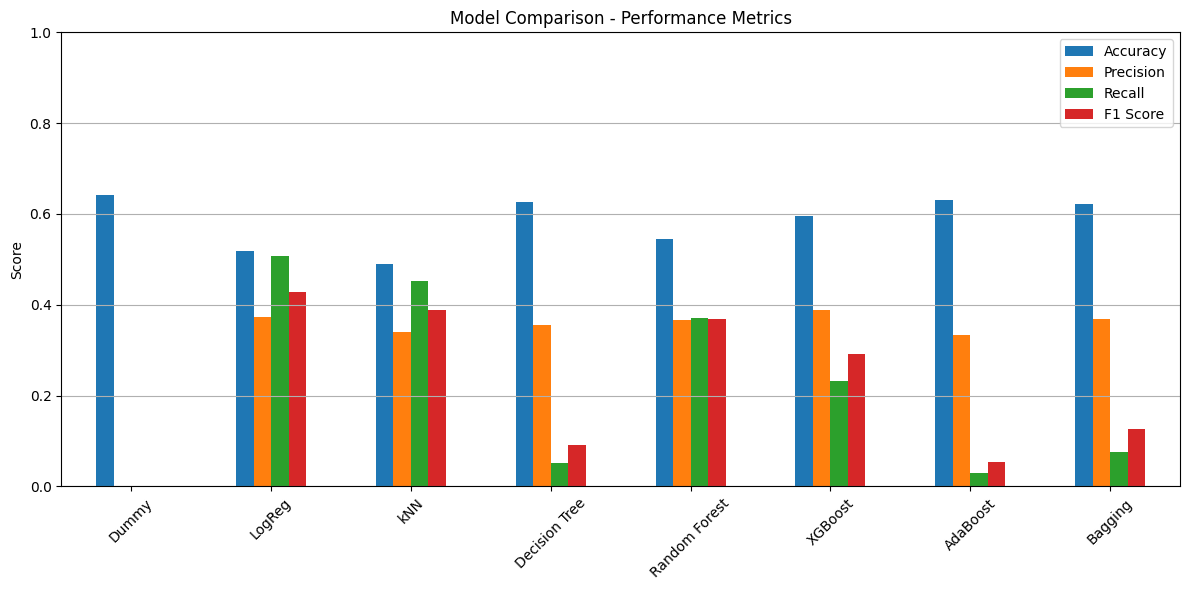

In [10]:
models = [
    'Dummy', 'LogReg', 'kNN', 'Decision Tree',
    'Random Forest', 'XGBoost', 'AdaBoost', 'Bagging'
]

metrics_df = pd.DataFrame({
    'Accuracy': [accuracy_score(y_test, p) for p in model_preds],
    'Precision': [precision_score(y_test, p, zero_division=0) for p in model_preds],
    'Recall': [recall_score(y_test, p, zero_division=0) for p in model_preds],
    'F1 Score': [f1_score(y_test, p, zero_division=0) for p in model_preds],
}, index=models)

metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison - Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Visualize Decision Tree Structure**

We created a decision tree model that displays the internal structure of the decision tree, showing how decisions are made based on features.

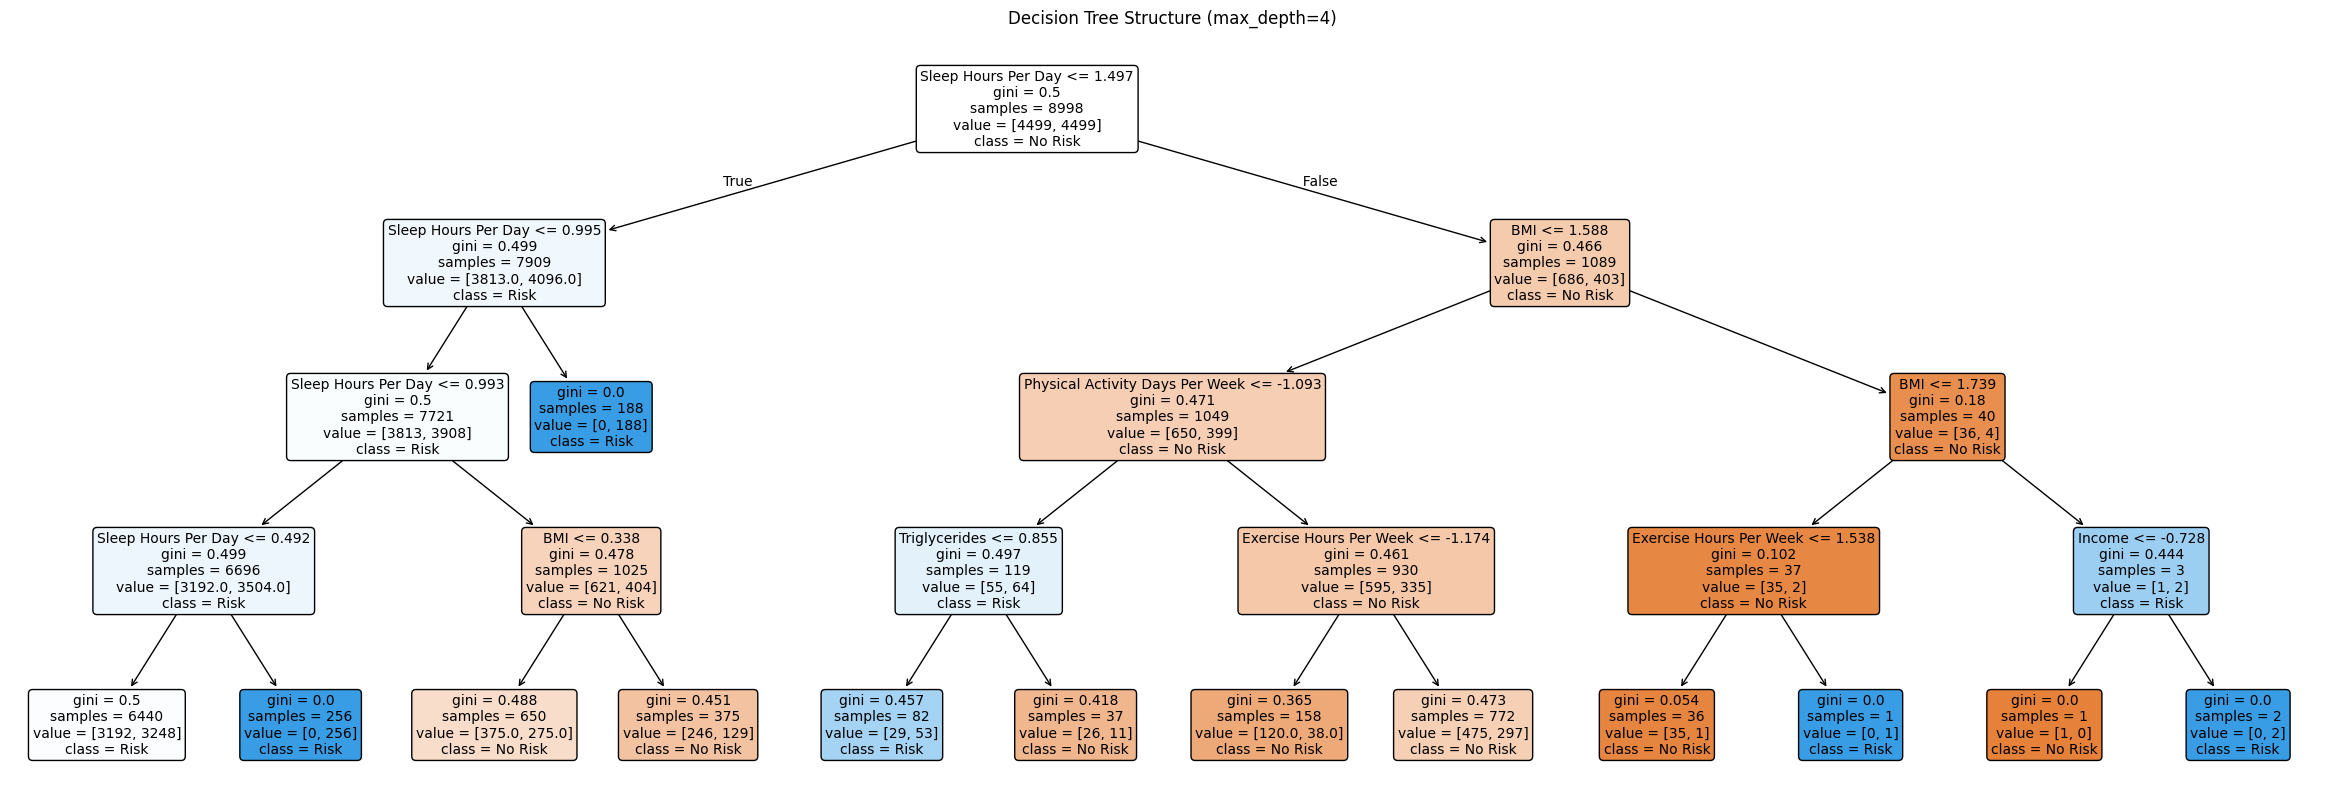

In [11]:
plt.figure(figsize=(30,10))
plot_tree(tree, feature_names=X.columns, class_names=['No Risk', 'Risk'], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Structure (max_depth=4)")
plt.show()

**ROC-AUC Curve**

This curve compares model performance in distinguishing classes. Higher AUC values indicate better classification. Ensemble models outperform baseline ones, while the diagonal shows random guessing.


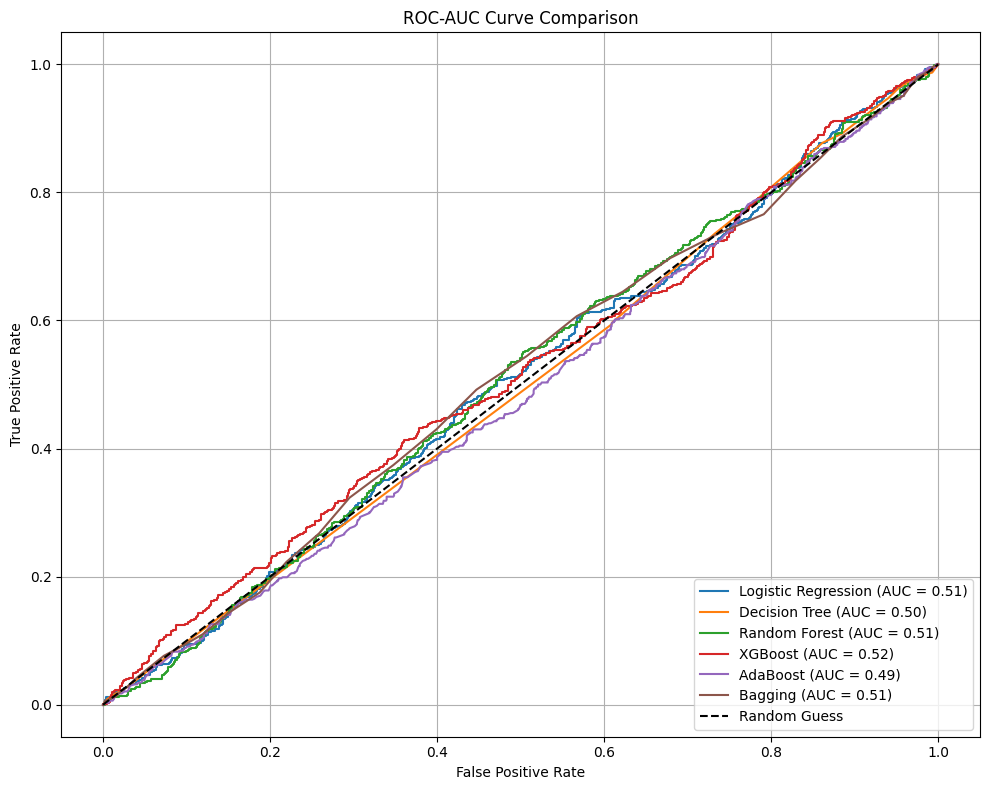

In [12]:
plt.figure(figsize=(10, 8))

models_probs = {
    "Logistic Regression": log_probs[:, 1],
    "Decision Tree": tree_probs[:, 1],
    "Random Forest": rf_probs[:, 1],
    "XGBoost": xgb_probs[:, 1],
    "AdaBoost": ada_probs[:, 1],
    "Bagging": bagging_probs[:, 1]
}

for name, probs in models_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
